In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## Load and Prepare Data

In [3]:
df = pd.read_csv('data.csv')

df['temp_date'] = pd.to_datetime(df['Date'].astype(str) + '-2020', format='%d-%b-%Y')
years = []
current_year = 2017
prev_month = 3  

for idx, row in df.iterrows():
    current_month = row['temp_date'].month
    if current_month < prev_month:
        current_year += 1
    years.append(current_year)
    prev_month = current_month

df['Year'] = years

date_strings = df['Year'].astype(str) + df['temp_date'].dt.strftime('-%m-%d')

df['Date'] = pd.to_datetime(date_strings)
df.set_index('Date', inplace=True)
df.drop(['temp_date', 'Year'], axis=1, inplace=True)

In [4]:
df

,1,2,3,4,5,6,7,8,9,10,...,7723955,30369354,34703847,36200067,36671067,37052366,38834077,39168240,39379024,Grand Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-22,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
2017-03-23,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85
2017-03-24,208.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126
2017-03-25,68.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
2017-03-26,46.0,48.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,NaN,47.0,NaN,NaN,26.0,28.0,74.0,NaN,25.0,NaN,...,NaN,30.0,NaN,67.0,39.0,28.0,27.0,116.0,34.0,42
2020-10-04,NaN,30.0,NaN,NaN,18.0,21.0,104.0,NaN,21.0,NaN,...,NaN,25.0,6.0,40.0,30.0,28.0,23.0,61.0,NaN,32
2020-10-05,NaN,30.0,NaN,NaN,17.0,20.0,75.0,NaN,18.0,NaN,...,NaN,24.0,NaN,37.0,29.0,23.0,20.0,67.0,NaN,31


In [5]:
stable_sensors = ['2', '5', '6', '9', '12']
df_sensors = df[stable_sensors]

df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')

df_sensors = df_sensors.asfreq('D')
df_sensors = df_sensors.interpolate(method='linear')

/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_3802/1537777980.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')


## CHANGE 1: Choose your approach

### Option A: Use AVERAGE of all sensors (RECOMMENDED)
This gives you a more robust overall AQI measure

In [6]:
'''df_2 = df_sensors[['2']]
df_2'''

"df_2 = df_sensors[['2']]\ndf_2"

In [7]:
'''data = pd.DataFrame()
#data['AQI'] = df_sensors.mean(axis=1)
data = df_2
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['2'])
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.title('Average AQI Over Time')
plt.show()'''

"data = pd.DataFrame()\n#data['AQI'] = df_sensors.mean(axis=1)\ndata = df_2\nplt.figure(figsize=(15, 5))\nplt.plot(data.index, data['2'])\nplt.xlabel('Date')\nplt.ylabel('Average AQI')\nplt.title('Average AQI Over Time')\nplt.show()"

### Option B: Use single sensor (Alternative)

In [8]:
# Option B: Single sensor (comment out if using Option A)
data = pd.DataFrame()
data['AQI'] = df_sensors['2']  # Use sensor 2

In [9]:
data

,AQI
Date,
2017-03-22,92.0
2017-03-23,85.0
2017-03-24,44.0
2017-03-25,59.0
2017-03-26,48.0
...,...
2020-10-03,47.0
2020-10-04,30.0
2020-10-05,30.0


## CHANGE 2: Modified prepare function for AQI
Same concept as stock prices, but clearer naming

In [10]:
# Modified data preparation for multi-step prediction
def prepare_dataframe_for_lstm(df, n_steps, n_future=30):
    """
    Prepare dataframe with lookback features
    n_steps: number of past days to use as features (lookback window)
    n_future: number of future days to predict (default 30)
    """
    df = df.copy()
    
    # Create lagged features (past values)
    for i in range(1, n_steps + 1):
        df[f'AQI(t-{i})'] = df['AQI'].shift(i)
    
    # Create future targets (next 30 days)
    for i in range(1, n_future + 1):
        df[f'AQI(t+{i})'] = df['AQI'].shift(-i)
    
    df.dropna(inplace=True)
    
    return df

lookback = 31
n_future = 30  # Predict 30 days ahead
shifted_df = prepare_dataframe_for_lstm(data, lookback, n_future)

print(f"Original data shape: {data.shape}")
print(f"After creating lagged features and future targets: {shifted_df.shape}")
print(f"Columns: {list(shifted_df.columns)}")
shifted_df.head(10)

Original data shape: (1296, 1)
After creating lagged features and future targets: (1235, 62)
Columns: ['AQI', 'AQI(t-1)', 'AQI(t-2)', 'AQI(t-3)', 'AQI(t-4)', 'AQI(t-5)', 'AQI(t-6)', 'AQI(t-7)', 'AQI(t-8)', 'AQI(t-9)', 'AQI(t-10)', 'AQI(t-11)', 'AQI(t-12)', 'AQI(t-13)', 'AQI(t-14)', 'AQI(t-15)', 'AQI(t-16)', 'AQI(t-17)', 'AQI(t-18)', 'AQI(t-19)', 'AQI(t-20)', 'AQI(t-21)', 'AQI(t-22)', 'AQI(t-23)', 'AQI(t-24)', 'AQI(t-25)', 'AQI(t-26)', 'AQI(t-27)', 'AQI(t-28)', 'AQI(t-29)', 'AQI(t-30)', 'AQI(t-31)', 'AQI(t+1)', 'AQI(t+2)', 'AQI(t+3)', 'AQI(t+4)', 'AQI(t+5)', 'AQI(t+6)', 'AQI(t+7)', 'AQI(t+8)', 'AQI(t+9)', 'AQI(t+10)', 'AQI(t+11)', 'AQI(t+12)', 'AQI(t+13)', 'AQI(t+14)', 'AQI(t+15)', 'AQI(t+16)', 'AQI(t+17)', 'AQI(t+18)', 'AQI(t+19)', 'AQI(t+20)', 'AQI(t+21)', 'AQI(t+22)', 'AQI(t+23)', 'AQI(t+24)', 'AQI(t+25)', 'AQI(t+26)', 'AQI(t+27)', 'AQI(t+28)', 'AQI(t+29)', 'AQI(t+30)']


,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7),AQI(t-8),AQI(t-9),...,AQI(t+21),AQI(t+22),AQI(t+23),AQI(t+24),AQI(t+25),AQI(t+26),AQI(t+27),AQI(t+28),AQI(t+29),AQI(t+30)
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-22,18.0,19.0,22.0,37.0,31.0,20.0,45.0,34.0,19.0,13.0,...,19.0,22.0,11.0,14.0,23.0,24.0,38.0,31.0,31.0,19.0
2017-04-23,20.0,18.0,19.0,22.0,37.0,31.0,20.0,45.0,34.0,19.0,...,22.0,11.0,14.0,23.0,24.0,38.0,31.0,31.0,19.0,11.0
2017-04-24,19.0,20.0,18.0,19.0,22.0,37.0,31.0,20.0,45.0,34.0,...,11.0,14.0,23.0,24.0,38.0,31.0,31.0,19.0,11.0,10.0
2017-04-25,19.0,19.0,20.0,18.0,19.0,22.0,37.0,31.0,20.0,45.0,...,14.0,23.0,24.0,38.0,31.0,31.0,19.0,11.0,10.0,12.0
2017-04-26,20.0,19.0,19.0,20.0,18.0,19.0,22.0,37.0,31.0,20.0,...,23.0,24.0,38.0,31.0,31.0,19.0,11.0,10.0,12.0,9.0
2017-04-27,10.0,20.0,19.0,19.0,20.0,18.0,19.0,22.0,37.0,31.0,...,24.0,38.0,31.0,31.0,19.0,11.0,10.0,12.0,9.0,11.0
2017-04-28,8.0,10.0,20.0,19.0,19.0,20.0,18.0,19.0,22.0,37.0,...,38.0,31.0,31.0,19.0,11.0,10.0,12.0,9.0,11.0,13.0
2017-04-29,19.0,8.0,10.0,20.0,19.0,19.0,20.0,18.0,19.0,22.0,...,31.0,31.0,19.0,11.0,10.0,12.0,9.0,11.0,13.0,9.0
2017-04-30,20.0,19.0,8.0,10.0,20.0,19.0,19.0,20.0,18.0,19.0,...,31.0,19.0,11.0,10.0,12.0,9.0,11.0,13.0,9.0,13.0


## From here, the code is EXACTLY the same as stock tutorial

In [11]:
shifted_df_as_np = shifted_df.to_numpy()
print("Shape:", shifted_df_as_np.shape)
print("First row:", shifted_df_as_np[0])

Shape: (1235, 62)
First row: [18.   19.   22.   37.   31.   20.   45.   34.   19.   13.    8.   22.
 50.   49.   44.   37.   35.75 34.5  33.25 32.   38.   24.   31.   30.
 31.   24.   26.   48.   59.   44.   85.   92.   20.   19.   19.   20.
 10.    8.   19.   20.   13.   30.   20.   27.   15.   18.   17.   24.
 16.   13.   11.   15.   19.   22.   11.   14.   23.   24.   38.   31.
 31.   19.  ]


In [12]:
'''# Normalize data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

print("After normalization:")
print(shifted_df_as_np[:5])'''

'# Normalize data to [-1, 1]\nscaler = MinMaxScaler(feature_range=(-1, 1))\nshifted_df_as_np = scaler.fit_transform(shifted_df_as_np)\n\nprint("After normalization:")\nprint(shifted_df_as_np[:5])'

In [13]:
# Split features and targets
shifted_df_as_np = shifted_df.to_numpy()

# X: columns 1 to lookback (past 31 days)
# y: columns lookback+1 to end (next 30 days)
X = shifted_df_as_np[:, 1:lookback+1]  # Past values (31 columns)
y = shifted_df_as_np[:, lookback+1:]   # Future values (30 columns)

print(f"X shape: {X.shape}  # (samples, lookback)")
print(f"y shape: {y.shape}  # (samples, future_steps)")
print(f"Each input uses {X.shape[1]} past days to predict {y.shape[1]} future days")

X shape: (1235, 31)  # (samples, lookback)
y shape: (1235, 30)  # (samples, future_steps)
Each input uses 31 past days to predict 30 future days


In [14]:
X = dc(np.flip(X, axis=1))
print("First sample features (t-7 to t-1):")
print(X[0])

First sample features (t-7 to t-1):
[92.   85.   44.   59.   48.   26.   24.   31.   30.   31.   24.   38.
 32.   33.25 34.5  35.75 37.   44.   49.   50.   22.    8.   13.   19.
 34.   45.   20.   31.   37.   22.   19.  ]


In [15]:
'''# Train/test split (95% train, 5% test)
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")'''

'# Train/test split (95% train, 5% test)\nsplit_index = int(len(X) * 0.95)\n\nX_train = X[:split_index]\nX_test = X[split_index:]\ny_train = y[:split_index]\ny_test = y[split_index:]\n\nprint(f"Training samples: {len(X_train)}")\nprint(f"Testing samples: {len(X_test)}")'

In [16]:
# Split data into train/test
split_index = int(len(shifted_df) * 0.80)

# Normalize the entire dataset first
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit scaler on training data only
train_data = shifted_df.iloc[:split_index].to_numpy()
scaler.fit(train_data)

# Transform all data
shifted_df_as_np = scaler.transform(shifted_df.to_numpy())

# Now split into X and y
X = shifted_df_as_np[:, 1:lookback+1]
y = shifted_df_as_np[:, lookback+1:]

# Train/test split
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Training samples: 988
Testing samples: 247
X_train shape: (988, 31)
y_train shape: (988, 30)


In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_scaled = scaler.fit_transform(train_data)

In [18]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Reshape X for LSTM: (batch, sequence_length, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

print(f"X_train shape: {X_train.shape}  # (batch, seq_len, features)")
print(f"y_train shape: {y_train.shape}  # (batch, output_steps)")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([988, 31, 1])  # (batch, seq_len, features)
y_train shape: torch.Size([988, 30])  # (batch, output_steps)
X_test shape: torch.Size([247, 31, 1])
y_test shape: torch.Size([247, 30])


In [19]:
# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print("After reshaping:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

After reshaping:
X_train: torch.Size([988, 31, 1])
X_test: torch.Size([247, 31, 1])
y_train: torch.Size([29640, 1])
y_test: torch.Size([7410, 1])


In [20]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print("Converted to PyTorch tensors")

Converted to PyTorch tensors


/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_3802/168454462.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_3802/168454462.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_3802/168454462.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T

In [21]:
# Create Dataset class
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [22]:
# Create DataLoaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 62
Number of test batches: 16


## LSTM Model - Same as stock tutorial

In [23]:
'''class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out'''

'class LSTM(nn.Module):\n    def __init__(self, input_size, hidden_size, num_stacked_layers):\n        super().__init__()\n        self.hidden_size = hidden_size\n        self.num_stacked_layers = num_stacked_layers\n\n        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, \n                            batch_first=True)\n        \n        self.fc = nn.Linear(hidden_size, 1)\n\n    def forward(self, x):\n        batch_size = x.size(0)\n        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)\n        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)\n        \n        out, _ = self.lstm(x, (h0, c0))\n        out = self.fc(out[:, -1, :])\n        return out'

In [25]:
device='cpu'

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size=30):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.output_size = output_size

        # Added dropout=0.2 to help with generalization
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, dropout=0.2 if num_stacked_layers > 1 else 0)
        
        # CHANGED: Now outputs 30 values directly instead of 1
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Shape: (batch_size, 30)
        return out

# NEW HYPERPARAMETERS
model = LSTM(input_size=1, hidden_size=64, num_stacked_layers=3, output_size=30)
model.to(device)
print(model)
print(f"\nModel predicts {model.output_size} future time steps")

LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=30, bias=True)
)

Model predicts 30 future time steps


In [27]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Create model
#model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
model.to(device)

print(model)

Using device: cpu
LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=30, bias=True)
)


In [28]:
# Training setup
learning_rate = 0.001
num_epochs = 200

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)

In [29]:
# Training loop
def train_one_epoch():
    model.train()
    running_loss = 0.0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Validation function
def validate():
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()
    
    return running_loss / len(test_loader)

In [30]:
# Train the model
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    val_loss = validate()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 30])).

Epoch 1/200, Train Loss: 0.203908, Val Loss: 0.049351
Epoch 2/200, Train Loss: 0.000690, Val Loss: 0.050753
Epoch 3/200, Train Loss: 0.000563, Val Loss: 0.052131
Epoch 4/200, Train Loss: 0.000517, Val Loss: 0.050859
Epoch 5/200, Train Loss: 0.000491, Val Loss: 0.051562
Epoch 6/200, Train Loss: 0.000457, Val Loss: 0.052851
Epoch 7/200, Train Loss: 0.000421, Val Loss: 0.053904
Epoch 8/200, Train Loss: 0.000392, Val Loss: 0.052250
Epoch 9/200, Train Loss: 0.000413, Val Loss: 0.050377
Epoch 10/200, Train Loss: 0.000381, Val Loss: 0.050105
Epoch 11/200, Train Loss: 0.000374, Val Loss: 0.048434
Epoch 12/200, Train Loss: 0.000369, Val Loss: 0.051188
Epoch 13/200, Train Loss: 0.000340, Val Loss: 0.048079
Epoch 14/200, Train Loss: 0.000346, Val Loss: 0.050087
Epoch 15/200, Train Loss: 0.000339, Val Loss: 0.052793
Epoch 16/200, Train Loss: 0.000332, Val Loss: 0.046156
Epoch 17/200, Train Loss: 0.000394, Val Loss: 0.047829
Epoch 18/200, Train Loss: 0.000335, Val Loss: 0.051770
Epoch 19/200, Train

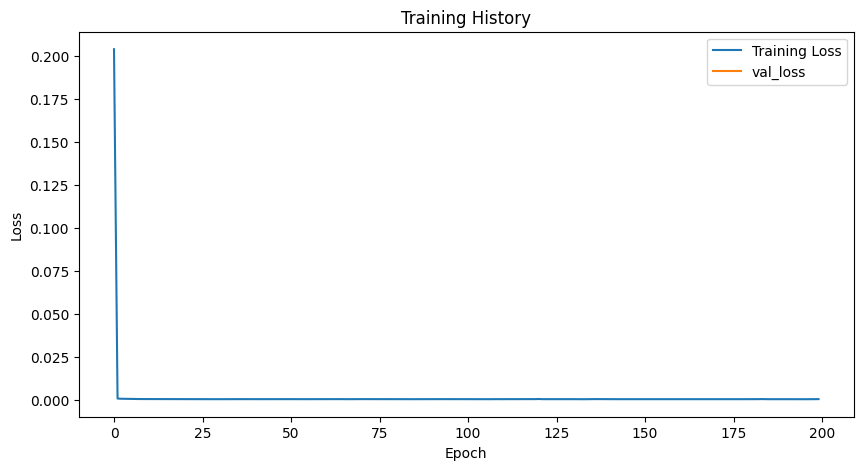

In [31]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

## Make Predictions

In [33]:
def inverse_transform_predictions(pred_values, actual_values, scaler, lookback=31, n_future=30):
    """
    Simple inverse transform for predictions
    """
    n_samples = len(pred_values)
    total_cols = 1 + lookback + n_future
    
    # Create dummy array with right shape
    dummy_pred = np.zeros((n_samples, total_cols))
    dummy_actual = np.zeros((n_samples, total_cols))
    
    # Place values in correct column position
    dummy_pred[:, lookback + 1] = pred_values
    dummy_actual[:, lookback + 1] = actual_values
    
    # Inverse transform
    pred_rescaled = scaler.inverse_transform(dummy_pred)[:, lookback + 1]
    actual_rescaled = scaler.inverse_transform(dummy_actual)[:, lookback + 1]
    
    return pred_rescaled, actual_rescaled

In [34]:
# Get predictions on test set
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()  # Shape: (n_samples, 30)
    
    # For evaluation, use only the first prediction (t+1)
    test_pred_t1 = test_predictions[:, 0:1]
    
    # Inverse transform
    padding_test = np.zeros((len(test_pred_t1), lookback + n_future - 1))
    test_pred_full = np.concatenate([np.zeros((len(test_pred_t1), lookback)),
                                      test_pred_t1,
                                      padding_test], axis=1)
    test_pred_t1_rescaled = scaler.inverse_transform(test_pred_full)[:, lookback]
    
    # Get actual test values (t+1)
    y_test_t1 = y_test[:, 0:1].numpy()
    y_test_full = np.concatenate([np.zeros((len(y_test_t1), lookback)),
                                   y_test_t1,
                                   np.zeros((len(y_test_t1), n_future - 1))], axis=1)
    y_test_actual = scaler.inverse_transform(y_test_full)[:, lookback]

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Using first step (t+1) for evaluation: {test_pred_t1_rescaled.shape}")

ValueError: operands could not be broadcast together with shapes (247,92) (62,) (247,92) 

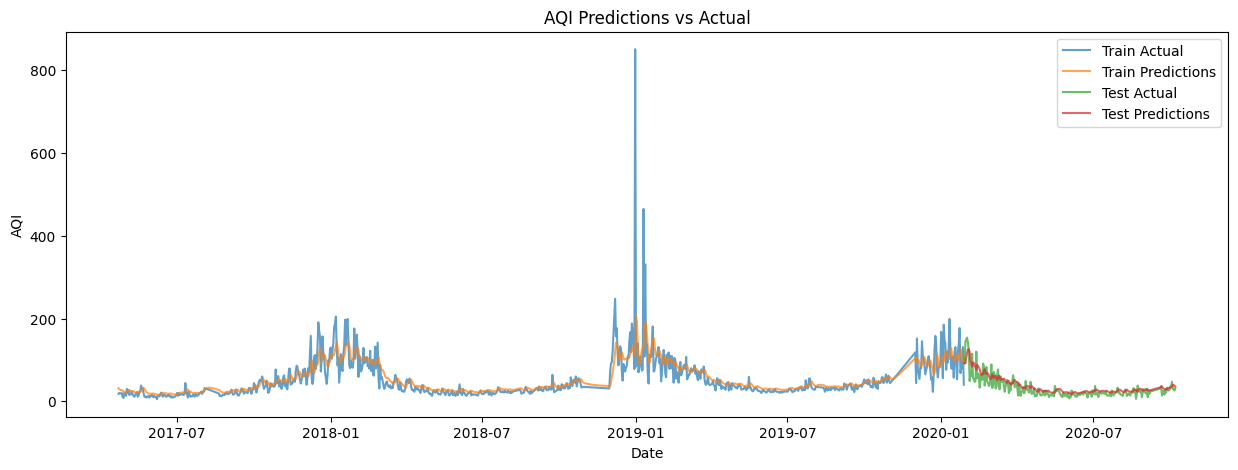

In [ ]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Get dates for plotting - need to adjust for shifted_df
train_dates = shifted_df.index[:split_index]
test_dates = shifted_df.index[split_index:]

plt.plot(train_dates, y_train_actual, label='Train Actual', alpha=0.7)
plt.plot(train_dates, train_pred_t1_rescaled, label='Train Predictions (t+1)', alpha=0.7)
plt.plot(test_dates, y_test_actual, label='Test Actual', alpha=0.7)
plt.plot(test_dates, test_pred_t1_rescaled, label='Test Predictions (t+1)', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI Predictions vs Actual (First Day of 30-day Forecast)')
plt.legend()
plt.show()

In [ ]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

train_mae = mean_absolute_error(y_train_actual, train_pred_t1_rescaled)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_t1_rescaled))
train_r2 = r2_score(y_train_actual, train_pred_t1_rescaled)

test_mae = mean_absolute_error(y_test_actual, test_pred_t1_rescaled)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_t1_rescaled))
test_r2 = r2_score(y_test_actual, test_pred_t1_rescaled)

train_mape = np.mean(np.abs((y_train_actual - train_pred_t1_rescaled) / np.maximum(y_train_actual, 1))) * 100
test_mape = np.mean(np.abs((y_test_actual - test_pred_t1_rescaled) / np.maximum(y_test_actual, 1))) * 100

print("Training Metrics (t+1 prediction):")
print(f"  MAE: {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  Average Error: {train_mape:.2f}%")
print(f"  R²: {train_r2 * 100:.2f}%")

print("\nTest Metrics (t+1 prediction):")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  Average Error: {test_mape:.2f}%")
print(f"  R²: {test_r2 * 100:.2f}%")

Training Metrics:
  MAE: 14.34
  RMSE: 33.27
  Average Error: 31.29%
  R²: 52.56%

Test Metrics:
  MAE: 10.59
  RMSE: 14.90
  Average Error: 44.29%
  R²: 61.33%


## Future Predictions (Optional)
Predict next N days

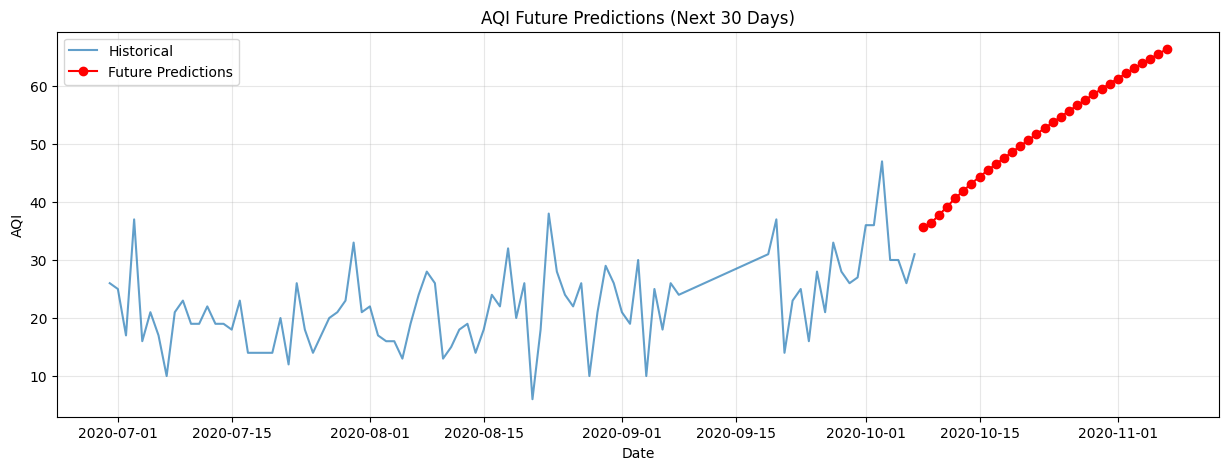


Future AQI Predictions:
2020-10-08: 35.63
2020-10-09: 36.36
2020-10-10: 37.73
2020-10-11: 39.20
2020-10-12: 40.62
2020-10-13: 41.95
2020-10-14: 43.18
2020-10-15: 44.34
2020-10-16: 45.45
2020-10-17: 46.52
2020-10-18: 47.57
2020-10-19: 48.61
2020-10-20: 49.64
2020-10-21: 50.67
2020-10-22: 51.69
2020-10-23: 52.70
2020-10-24: 53.71
2020-10-25: 54.70
2020-10-26: 55.69
2020-10-27: 56.66
2020-10-28: 57.61
2020-10-29: 58.55
2020-10-30: 59.47
2020-10-31: 60.38
2020-11-01: 61.28
2020-11-02: 62.16
2020-11-03: 63.02
2020-11-04: 63.87
2020-11-05: 64.70
2020-11-06: 65.52
2020-11-07: 66.33


In [ ]:
# Predict future 30 days with the new model
def predict_future_multistep(model, last_sequence, scaler, device, lookback=31, n_future=30):
    """
    Predict next 30 days using the multi-output model
    
    Args:
        model: trained LSTM model with 30 outputs
        last_sequence: last 'lookback' days of normalized data
        scaler: fitted MinMaxScaler
        device: torch device
        lookback: number of input days
        n_future: number of future days (30)
    
    Returns:
        Array of 30 predicted AQI values
    """
    model.eval()
    
    with torch.no_grad():
        # Prepare input: reshape to (1, lookback, 1)
        x = torch.tensor(last_sequence).float().reshape(1, lookback, 1).to(device)
        
        # Get all 30 predictions at once
        predictions = model(x).cpu().numpy()[0]  # Shape: (30,)
    
    # Inverse transform
    # Create full array with padding for inverse transform
    pred_full = np.concatenate([
        np.zeros((n_future, lookback)),
        predictions.reshape(-1, 1),
        np.zeros((n_future, n_future - 1))
    ], axis=1)
    
    # Inverse transform each prediction
    predictions_rescaled = scaler.inverse_transform(pred_full)[:, lookback]
    
    return predictions_rescaled

# Get last sequence from test data (last 31 days of actual data)
last_sequence = X_test[-1].cpu().numpy().flatten()

# Predict next 30 days
future_predictions = predict_future_multistep(model, last_sequence, scaler, device, lookback, n_future)

# Create future dates
import pandas as pd
last_date = shifted_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot historical + future
plt.figure(figsize=(15, 6))

# Plot last 90 days of actual data
plot_days = 90
plot_start = max(0, len(shifted_df) - plot_days)
historical_dates = shifted_df.index[plot_start:]
historical_values = scaler.inverse_transform(shifted_df.iloc[plot_start:].to_numpy())[:, 0]

plt.plot(historical_dates, historical_values, label='Historical AQI', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label='30-Day Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)

plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI: Historical Data and 30-Day Forecast (Direct Multi-Step Prediction)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n30-Day Forecast:")
for i, (date, pred) in enumerate(zip(future_dates, future_predictions), 1):
    print(f"Day {i} ({date.strftime('%Y-%m-%d')}): {pred:.1f} AQI")